<a href="https://colab.research.google.com/github/ioskn/mldl_htwg/blob/master/linear_methods/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook demonstrating Linear Regression (Curve Fitting)

This notebook demonstrates the curve fitting part of linear regression. 

*Please note that we did not split the data into a training and test set as one should do*. This notbook is just for illustration.

In [2]:
#This is just for the autodiff part at the end. Not really needed.
import tensorflow as tf
import tensorflow_probability as tfp
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
# Some imports
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns

#To make ploting consitent
sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline
plt.style.use('default')
np.random.seed(42)
import pandas as pd

In [4]:
# The adverting data set from ILSR
import os
from urllib.request import urlretrieve
if not os.path.isfile('Advertising.csv'):
    print("Downloading")
    urlretrieve('https://raw.githubusercontent.com/ioskn/mldl_htwg/master/data/Advertising.csv',filename = 'Advertising.csv')
advertising = pd.read_csv('Advertising.csv', usecols=[1,2,3,4])
advertising.insert(0, 'Intercept',np.ones((200,1)))
advertising

Downloading


,Intercept,TV,Radio,Newspaper,Sales
0,1.0,230.1,37.8,69.2,22.1
1,1.0,44.5,39.3,45.1,10.4
2,1.0,17.2,45.9,69.3,9.3
3,1.0,151.5,41.3,58.5,18.5
4,1.0,180.8,10.8,58.4,12.9
...,...,...,...,...,...
195,1.0,38.2,3.7,13.8,7.6
196,1.0,94.2,4.9,8.1,9.7
197,1.0,177.0,9.3,6.4,12.8
198,1.0,283.6,42.0,66.2,25.5


In [5]:
y = np.asmatrix(advertising['Sales'])[0].T
X = np.asmatrix(advertising.iloc[:,0:4])
N = y.shape[0] #200
print(X[0:3])
y.shape, X.shape

[[  1.  230.1  37.8  69.2]
 [  1.   44.5  39.3  45.1]
 [  1.   17.2  45.9  69.3]]


((200, 1), (200, 4))

In [6]:
w = np.ones((4)) #Setting w = 1 just for demonstration w is not trained
d = np.matmul(X,w)
d[:,1:10]

matrix([[129.9, 133.4, 252.3, 251. , 133.6, 114.8, 152.4,  12.7, 224.6]])

### Solving the linear regression

$$
(𝑋^𝑇 𝑋)^{(−1)} 𝑋^𝑇 𝑦
$$

####  "By Hand"

Just for demonstration of the formula. Numerically probably not very stable.

In [7]:
XTX = np.matmul(X.T,X)
XTXI = np.linalg.inv(XTX)
XTXIXT = np.matmul(XTXI, X.T)
w = np.matmul(XTXIXT,y)
w

matrix([[ 2.93888937e+00],
        [ 4.57646455e-02],
        [ 1.88530017e-01],
        [-1.03749304e-03]])

In [8]:
np.mean(np.square((np.matmul(X,w).flatten() - y.flatten()))) # The MSE

2.784126314510936

#### Using sklearn

In [13]:
from sklearn.linear_model import LinearRegression
Xa = np.asarray(X) #sklearn is picky and needs numpy arrays
ya = np.asarray(y)
model_skl = LinearRegression(fit_intercept=False) #We have an extended X
model_skl.fit(Xa,ya)
model_skl.coef_

array([[ 2.93888937e+00,  4.57646455e-02,  1.88530017e-01,
        -1.03749304e-03]])

### Looking at the solution

2.784126314510936

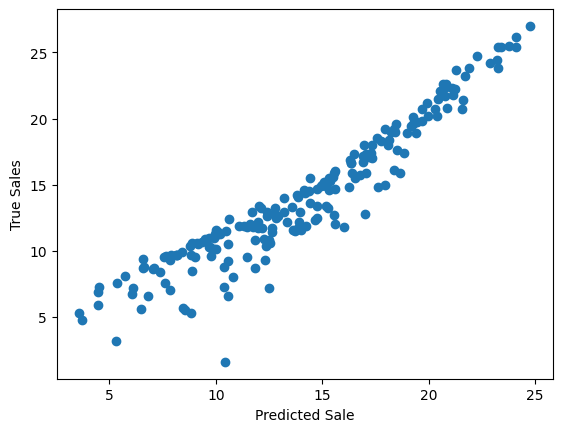

In [14]:
y_pred = np.matmul(X,w)
plt.scatter([y_pred[:,0]], [y[:,0]])
plt.xlabel('Predicted Sale')
plt.ylabel('True Sales')

np.mean(np.square((y_pred[:,0] - y[:,0]))) # The MSE

### Using gradient descent [Just for reference]

Note that linear regression should be solved as above. But just to show the framework

In [15]:
Xs = tf.Variable(np.asmatrix(X,dtype='float32'))
#ws = tf.Variable((1.,1.,1.,1))
ws = tf.Variable(1.2 * np.asarray(w,dtype='float32'))
for i in range(5000):
    with tf.GradientTape() as tape: #Mechanism to store gradients
        y_hat = tf.matmul(Xs,ws)
        loss = tf.reduce_mean((y - y_hat)**2) #MSE
        if (i % 500 == 0):
            print(i, "  ",ws.numpy().T,'  ',loss.numpy())
        grads = tape.gradient(loss, ws) #gradient wrt w
        ws = tf.Variable(ws - 0.00001 * grads)

NameError: name 'tf' is not defined

Comparison, longer traning would yield better results. 

In [ ]:
np.mean(np.square((y_hat.numpy().flatten() - y.flatten()))) # The MSE, a bit higher then analytical solution

2.833049790521394

Text(0, 0.5, 'Gradient Descent')

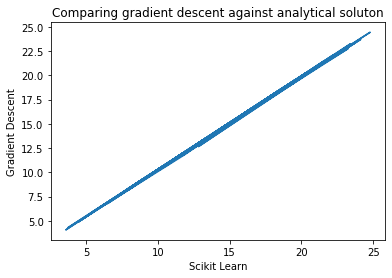

In [ ]:
plt.plot(y_pred,y_hat)
plt.title('Comparing gradient descent against analytical soluton')
plt.xlabel('Scikit Learn')
plt.ylabel('Gradient Descent')